# Halpha Emitters S-PLUS

In [2]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib.pyplot as plt
from itertools import combinations
import umap
import seaborn as sns; sns.set()
sns.set_theme(style="ticks")

In [3]:
# Read the ASCII file into an Astropy Table
data_gc = Table.read("catalogo_gcs_spectroscopio_splus_detected.dat", format='ascii')

In [4]:
data_gc

NUMBER,ALPHA,DELTA,u,uerr,g,gerr,r,rerr,i,ierr,z,zerr,F378,F378err,F395,F395err,F410,F410err,F430,F430err,F515,F515err,F660,F660err,F861,F861err,fwhm_i,fwhm_psf_i,ellog_i,ellip_i,class_i,spread_i,flux_radius_i,area_i,a_image,b_image,theta_image,kron_radius
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
16253,52.65439772166957,-34.85515754646527,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,21.509762,0.4309228,99.0,99.0,99.0,99.0,20.985655,0.4293076,3.964676,1.36,1.2672191,0.21087044,0.6723346,-0.009377983,0.7654491,6,0.88541776,0.6987093,62.493454,3.5
16306,52.63961882667077,-34.85291674010414,99.0,99.0,21.505468,0.14491467,99.0,99.0,21.089676,0.12166906,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,21.286818,0.1148665,99.0,99.0,5.630442,1.36,1.0972694,0.08864683,0.06164774,0.007863585,2.1781638,11,0.9900843,0.90231645,77.92344,0.0
16324,52.65275307842115,-34.852162476132385,99.0,99.0,22.298355,0.28719342,21.956337,0.21723434,99.0,99.0,20.88752,0.37852666,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,5.430654,1.36,2.0048974,0.50122136,0.12759903,0.012198187,4.5430984,9,1.2915813,0.64421314,-70.62824,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9334,56.47080809237188,-36.38100972247008,99.0,99.0,21.297062,0.125005,21.1502,0.10246985,20.946495,0.16598357,20.752363,0.27112925,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,20.76066,0.23253353,3.9593022,1.57,1.1740693,0.14826149,0.5053883,0.0020354611,1.5784603,7,1.0848621,0.92401886,45.381638,3.5
9556,56.476602899451976,-36.36934614745525,22.283209,0.46388647,21.293524,0.19573519,21.11891,0.102101564,21.128262,0.19630142,99.0,99.0,99.0,99.0,99.0,99.0,21.681,0.63275254,99.0,99.0,99.0,99.0,21.405947,0.26114392,99.0,99.0,5.8482294,1.57,1.3886453,0.27987373,0.0013462513,-0.025030501,4.501121,10,1.1562408,0.8326394,44.67632,8.414255
16401,55.18251262183341,-37.5132939995927,99.0,99.0,21.777725,0.1559404,20.925825,0.077992685,20.560007,0.08819846,20.334112,0.116739966,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,21.52708,0.3209823,20.891365,0.09095458,20.45169,0.15346812,5.062865,1.36,1.2495975,0.19974238,0.26691622,0.0017418955,1.157217,16,1.3039578,1.0435022,11.0807,4.428755
17983,55.18623156077027,-37.50601568687407,99.0,99.0,99.0,99.0,22.188572,0.24488313,99.0,99.0,21.071108,0.21801461,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,22.911451,0.68460155,99.0,99.0,2.8162916,1.61,1.0640013,0.060151517,0.50032973,-0.013312716,1.599141,4,0.7170122,0.67388284,-4.1274004,0.0


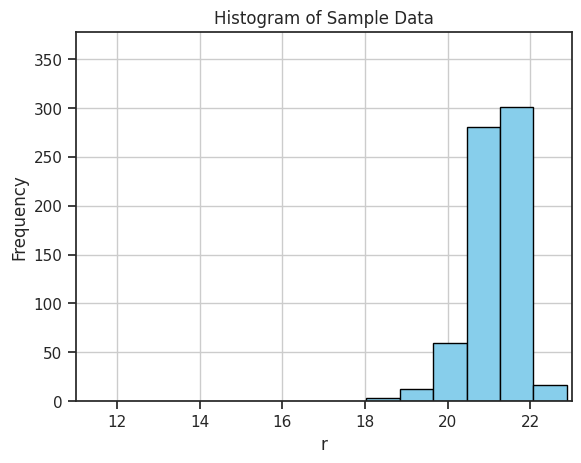

In [44]:
# See the distance of the SPLUS nad WISE source
# Plotting the histogram
plt.hist(data_gc["r"], bins=100, color='skyblue', edgecolor='black')  # You can adjust the number of bins as needed
plt.xlim(11, 23)
plt.title('Histogram of Sample Data')
plt.xlabel('r')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid lines for better readability
plt.show()

In [5]:
data_nogc = Table.read("catalogo_contaminates_splus_detected.dat", format='ascii')

In [6]:
data_nogc

NUMBER,ALPHA,DELTA,u,uerr,g,gerr,r,rerr,i,ierr,z,zerr,F378,F378err,F395,F395err,F410,F410err,F430,F430err,F515,F515err,F660,F660err,F861,F861err,fwhm_i,fwhm_psf_i,ellog_i,ellip_i,class_i,spread_i,flux_radius_i,area_i,a_image,b_image,theta_image,kron_radius
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
3044,42.8470453260897,-31.37096740340893,11.651432,0.00058115856,11.368085,0.00042013926,11.751593,0.00045861208,11.450518,0.00053494854,99.0,99.0,11.214559,0.00069241226,11.151755,0.00091673894,10.712489,0.00066051556,10.656315,0.00060870434,10.291095,0.00045840707,11.636211,0.00070510135,10.723624,0.0006034137,27.459143,1.35,1.2703147,0.21279353,0.9611419,0.038238447,3.8342078,4338,5.156732,4.059413,-87.82511,3.5
9170,42.955755566099235,-31.085048864463147,13.71948,0.0015239846,11.511275,0.0004175872,11.901758,0.0005072665,11.800021,0.0005736633,11.366286,0.00050563744,13.503729,0.0020148547,13.112395,0.0022906233,12.322975,0.0013967738,12.060535,0.0011685397,11.278885,0.0007235725,11.3758335,0.00044918057,10.704217,0.00048655522,21.800894,1.35,1.1450231,0.12665522,0.96872544,0.04455381,3.3162627,2909,4.1713743,3.643048,-78.25398,3.5
9496,42.955829920033665,-31.033536365326555,11.601796,0.0005681798,11.607529,0.0005134674,11.759823,0.00044733495,11.713865,0.00046415016,99.0,99.0,11.206919,0.0006902779,11.14801,0.00091403816,10.587264,0.0006237736,10.514495,0.0005705591,10.128576,0.0004252827,99.0,99.0,99.0,99.0,37.673557,1.35,1.7743977,0.4364285,0.95908266,0.03368139,5.0185037,5172,8.360392,4.7116785,77.561134,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30953,57.16198861364776,-40.76741940176112,17.96597,0.021197144,16.303978,0.0070542106,15.721187,0.0045641735,15.550023,0.0043057404,15.479434,0.005177417,17.70351,0.028519781,17.558945,0.04005217,16.839209,0.028966261,16.81151,0.022893578,16.123583,0.012699494,15.673627,0.0051730014,15.517522,0.0072734025,2.5084007,1.21,1.0312828,0.030333817,0.96860516,0.00073051616,1.532388,231,2.2232933,2.1558523,-63.319294,3.5
31085,56.977210991062634,-40.7693352357865,18.106148,0.022910615,16.557777,0.008002474,16.063084,0.0053821797,15.940112,0.005217299,15.889799,0.006404641,17.701815,0.028450945,17.646553,0.042358395,16.99822,0.031713355,16.958448,0.024874777,16.393812,0.014702361,16.033278,0.006164425,15.924335,0.008918502,2.592889,1.21,1.0791507,0.07334536,0.9978194,0.00065552996,1.5197918,169,2.1194952,1.96404,85.50194,3.5
31195,57.49807784370211,-40.75975504877154,16.90086,0.012032937,15.565959,0.004925989,15.08202,0.003360673,14.947059,0.0032139819,14.9115925,0.0038674702,16.583548,0.015500822,16.523436,0.02203128,15.988348,0.018256238,15.94959,0.014310922,15.412489,0.008862887,15.070141,0.003871385,14.933365,0.005434147,2.6188831,1.21,1.0540731,0.051299155,0.97691643,0.0011775164,1.5092492,308,2.3088677,2.1904247,55.97485,3.5
31432,56.61142617222227,-40.79469001762723,18.322006,0.025660768,16.547096,0.007946467,15.915723,0.0050036823,15.739915,0.0047240905,15.6672325,0.0057043945,18.039152,0.034428254,17.95078,0.050961383,17.20725,0.03566981,17.065674,0.026349995,16.369896,0.014442796,15.854458,0.005642479,15.688582,0.0079153385,2.8052514,1.21,1.0193923,0.0190233,0.99165857,0.00036924306,1.5038267,219,2.2311075,2.1886644,52.5266,3.5


In [7]:
#Convert in pandas
df_gc = data_gc.to_pandas()
df_nogc = data_nogc.to_pandas()

In [8]:
# Add a new column named 'label' with value 0 to df1
df_gc['label'] = 0

# Add a new column named 'label' with value 1 to df2
df_nogc['label'] = 1

In [9]:
df_gc

,NUMBER,ALPHA,DELTA,u,uerr,g,gerr,r,rerr,i,...,ellip_i,class_i,spread_i,flux_radius_i,area_i,a_image,b_image,theta_image,kron_radius,label
0,16253,52.654398,-34.855158,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,0.210870,0.672335,-0.009378,0.765449,6,0.885418,0.698709,62.493454,3.500000,0
1,16306,52.639619,-34.852917,99.000000,99.000000,21.505468,0.144915,99.000000,99.000000,21.089676,...,0.088647,0.061648,0.007864,2.178164,11,0.990084,0.902316,77.923440,0.000000,0
2,16324,52.652753,-34.852162,99.000000,99.000000,22.298355,0.287193,21.956337,0.217234,99.000000,...,0.501221,0.127599,0.012198,4.543098,9,1.291581,0.644213,-70.628240,0.000000,0
3,16364,52.633772,-34.850723,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,0.412349,0.483887,0.000314,1.132125,3,0.758583,0.445783,-19.666363,5.918421,0
4,16390,52.628347,-34.849198,99.000000,99.000000,22.041685,0.221051,21.017162,0.083320,20.517560,...,0.228112,0.888689,0.002040,1.664508,16,1.312094,1.012789,-70.396620,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,23790,54.337295,-35.542888,99.000000,99.000000,99.000000,99.000000,21.897480,0.765113,21.168234,...,0.431805,0.430043,0.002078,1.609534,2,0.580760,0.329985,47.396320,0.000000,0
1030,9334,56.470808,-36.381010,99.000000,99.000000,21.297062,0.125005,21.150200,0.102470,20.946495,...,0.148261,0.505388,0.002035,1.578460,7,1.084862,0.924019,45.381638,3.500000,0
1031,9556,56.476603,-36.369346,22.283209,0.463886,21.293524,0.195735,21.118910,0.102102,21.128262,...,0.279874,0.001346,-0.025031,4.501121,10,1.156241,0.832639,44.676320,8.414255,0
1032,16401,55.182513,-37.513294,99.000000,99.000000,21.777725,0.155940,20.925825,0.077993,20.560007,...,0.199742,0.266916,0.001742,1.157217,16,1.303958,1.043502,11.080700,4.428755,0


In [10]:
# Assuming df1 and df2 are your Pandas DataFrames
for i, df in enumerate([df_gc, df_nogc]):
    print(f"Columns of DataFrame {i + 1}:")
    print(df.columns)


Columns of DataFrame 1:
Index(['NUMBER', 'ALPHA', 'DELTA', 'u', 'uerr', 'g', 'gerr', 'r', 'rerr', 'i',
       'ierr', 'z', 'zerr', 'F378', 'F378err', 'F395', 'F395err', 'F410',
       'F410err', 'F430', 'F430err', 'F515', 'F515err', 'F660', 'F660err',
       'F861', 'F861err', 'fwhm_i', 'fwhm_psf_i', 'ellog_i', 'ellip_i',
       'class_i', 'spread_i', 'flux_radius_i', 'area_i', 'a_image', 'b_image',
       'theta_image', 'kron_radius', 'label'],
      dtype='object')
Columns of DataFrame 2:
Index(['NUMBER', 'ALPHA', 'DELTA', 'u', 'uerr', 'g', 'gerr', 'r', 'rerr', 'i',
       'ierr', 'z', 'zerr', 'F378', 'F378err', 'F395', 'F395err', 'F410',
       'F410err', 'F430', 'F430err', 'F515', 'F515err', 'F660', 'F660err',
       'F861', 'F861err', 'fwhm_i', 'fwhm_psf_i', 'ellog_i', 'ellip_i',
       'class_i', 'spread_i', 'flux_radius_i', 'area_i', 'a_image', 'b_image',
       'theta_image', 'kron_radius', 'label'],
      dtype='object')


In [11]:
# Concatenate the two DataFrames vertically
combined_df = pd.concat([df_gc, df_nogc], ignore_index=True)
len(combined_df)

27152

In [12]:
for columns in combined_df.columns:
    print(columns)

NUMBER
ALPHA
DELTA
u
uerr
g
gerr
r
rerr
i
ierr
z
zerr
F378
F378err
F395
F395err
F410
F410err
F430
F430err
F515
F515err
F660
F660err
F861
F861err
fwhm_i
fwhm_psf_i
ellog_i
ellip_i
class_i
spread_i
flux_radius_i
area_i
a_image
b_image
theta_image
kron_radius
label


In [13]:
# Cleaned error


m_err = (combined_df["rerr"] <= 0.3) & (combined_df["gerr"] <= 0.3) & \
        (combined_df["ierr"] <= 0.3) & \
         (combined_df["F430err"] <= 0.3) & \
        (combined_df["F515err"] <= 0.3) & (combined_df["F660err"] <= 0.3) & \
        (combined_df["F861err"] <= 0.3) & (combined_df["zerr"] <= 0.3)



17168

In [15]:
mask0 = df_cleanErr["label"] == 0
mask1 = df_cleanErr["label"] == 1

print(len(df_cleanErr[mask0]))
print(len(df_cleanErr[mask1]))

73
17095


In [16]:
#Selecting columns
columns = ["r",
"g",
"i",
"z",
"F430",
"F515",
"F660",
"F861"]

In [17]:
df_mag = df_cleanErr[columns]
df_mag

,r,g,i,z,F430,F515,F660,F861
18,20.771109,21.634192,20.403067,20.642290,21.397750,21.053720,20.602430,20.654783
19,20.137680,21.452078,19.779497,19.552048,21.201336,20.714169,20.130114,19.531912
25,20.246616,21.061428,20.222399,20.175852,20.992937,20.684935,20.479723,19.814960
28,18.024874,18.803331,17.634941,17.343376,19.499080,18.669243,17.865160,17.431444
38,19.519290,20.294525,19.167469,19.019533,20.706673,20.065145,19.382828,19.034452
...,...,...,...,...,...,...,...,...
27147,14.743249,14.965096,14.748895,14.796816,15.080612,14.838267,14.801393,14.790771
27148,15.721187,16.303978,15.550023,15.479434,16.811510,16.123583,15.673627,15.517522
27149,16.063084,16.557777,15.940112,15.889799,16.958448,16.393812,16.033278,15.924335
27150,15.082020,15.565959,14.947059,14.911592,15.949590,15.412489,15.070141,14.933365


### Creating the colors 

In [18]:
# Generate all combinations of magnitude columns
color_index_pairs = list(combinations(df_mag, 2))
len(color_index_pairs)

28

In [19]:
def calculate_earnings(df, index_pairs):
    for index_pair in index_pairs:
        color_index_name = f"{index_pair[0]} - {index_pair[1]}"
        df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
    return df

In [20]:
df_colors_mag = calculate_earnings(df_mag, color_index_pairs)

/tmp/ipykernel_1336541/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_1336541/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_1336541/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [21]:
df_colors_mag

,r,g,i,z,F430,F515,F660,F861,r - g,r - i,...,z - F430,z - F515,z - F660,z - F861,F430 - F515,F430 - F660,F430 - F861,F515 - F660,F515 - F861,F660 - F861
18,20.771109,21.634192,20.403067,20.642290,21.397750,21.053720,20.602430,20.654783,-0.863083,0.368042,...,-0.755460,-0.411430,0.039860,-0.012493,0.344030,0.795320,0.742967,0.451290,0.398937,-0.052353
19,20.137680,21.452078,19.779497,19.552048,21.201336,20.714169,20.130114,19.531912,-1.314398,0.358183,...,-1.649288,-1.162121,-0.578066,0.020136,0.487167,1.071222,1.669424,0.584055,1.182257,0.598202
25,20.246616,21.061428,20.222399,20.175852,20.992937,20.684935,20.479723,19.814960,-0.814812,0.024217,...,-0.817085,-0.509083,-0.303871,0.360892,0.308002,0.513214,1.177977,0.205212,0.869975,0.664763
28,18.024874,18.803331,17.634941,17.343376,19.499080,18.669243,17.865160,17.431444,-0.778457,0.389933,...,-2.155704,-1.325867,-0.521784,-0.088068,0.829837,1.633920,2.067636,0.804083,1.237799,0.433716
38,19.519290,20.294525,19.167469,19.019533,20.706673,20.065145,19.382828,19.034452,-0.775235,0.351821,...,-1.687140,-1.045612,-0.363295,-0.014919,0.641528,1.323845,1.672221,0.682317,1.030693,0.348376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27147,14.743249,14.965096,14.748895,14.796816,15.080612,14.838267,14.801393,14.790771,-0.221847,-0.005646,...,-0.283796,-0.041451,-0.004577,0.006044,0.242345,0.279219,0.289841,0.036874,0.047496,0.010622
27148,15.721187,16.303978,15.550023,15.479434,16.811510,16.123583,15.673627,15.517522,-0.582791,0.171164,...,-1.332076,-0.644149,-0.194193,-0.038088,0.687927,1.137883,1.293988,0.449956,0.606061,0.156105
27149,16.063084,16.557777,15.940112,15.889799,16.958448,16.393812,16.033278,15.924335,-0.494693,0.122972,...,-1.068649,-0.504013,-0.143479,-0.034536,0.564636,0.925170,1.034113,0.360534,0.469477,0.108943
27150,15.082020,15.565959,14.947059,14.911592,15.949590,15.412489,15.070141,14.933365,-0.483939,0.134961,...,-1.037998,-0.500897,-0.158549,-0.021773,0.537101,0.879449,1.016225,0.342348,0.479124,0.136776


In [22]:
# Drop magniytudes
df_colors = df_colors_mag.drop(columns=columns)

In [23]:
df_colors

,r - g,r - i,r - z,r - F430,r - F515,r - F660,r - F861,g - i,g - z,g - F430,...,z - F430,z - F515,z - F660,z - F861,F430 - F515,F430 - F660,F430 - F861,F515 - F660,F515 - F861,F660 - F861
18,-0.863083,0.368042,0.128819,-0.626641,-0.282611,0.168679,0.116326,1.231125,0.991902,0.236442,...,-0.755460,-0.411430,0.039860,-0.012493,0.344030,0.795320,0.742967,0.451290,0.398937,-0.052353
19,-1.314398,0.358183,0.585632,-1.063656,-0.576489,0.007566,0.605768,1.672581,1.900030,0.250742,...,-1.649288,-1.162121,-0.578066,0.020136,0.487167,1.071222,1.669424,0.584055,1.182257,0.598202
25,-0.814812,0.024217,0.070764,-0.746321,-0.438319,-0.233107,0.431656,0.839029,0.885576,0.068491,...,-0.817085,-0.509083,-0.303871,0.360892,0.308002,0.513214,1.177977,0.205212,0.869975,0.664763
28,-0.778457,0.389933,0.681498,-1.474206,-0.644369,0.159714,0.593430,1.168390,1.459955,-0.695749,...,-2.155704,-1.325867,-0.521784,-0.088068,0.829837,1.633920,2.067636,0.804083,1.237799,0.433716
38,-0.775235,0.351821,0.499757,-1.187383,-0.545855,0.136462,0.484838,1.127056,1.274992,-0.412148,...,-1.687140,-1.045612,-0.363295,-0.014919,0.641528,1.323845,1.672221,0.682317,1.030693,0.348376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27147,-0.221847,-0.005646,-0.053567,-0.337363,-0.095018,-0.058144,-0.047522,0.216201,0.168280,-0.115516,...,-0.283796,-0.041451,-0.004577,0.006044,0.242345,0.279219,0.289841,0.036874,0.047496,0.010622
27148,-0.582791,0.171164,0.241753,-1.090323,-0.402396,0.047560,0.203665,0.753955,0.824544,-0.507532,...,-1.332076,-0.644149,-0.194193,-0.038088,0.687927,1.137883,1.293988,0.449956,0.606061,0.156105
27149,-0.494693,0.122972,0.173285,-0.895364,-0.330728,0.029806,0.138749,0.617665,0.667978,-0.400671,...,-1.068649,-0.504013,-0.143479,-0.034536,0.564636,0.925170,1.034113,0.360534,0.469477,0.108943
27150,-0.483939,0.134961,0.170428,-0.867570,-0.330469,0.011879,0.148655,0.618900,0.654367,-0.383631,...,-1.037998,-0.500897,-0.158549,-0.021773,0.537101,0.879449,1.016225,0.342348,0.479124,0.136776


# Reduction dimensionality

## UMAP 

Given that there are 66 variables, we use UMAP. I think UMAP is the best option because these variables are probably not linearly correlated. [UMAP](https://umap-learn.readthedocs.io/en/latest/) (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique commonly used for visualizing high-dimensional data in lower-dimensional spaces. If you have 66 variables and suspect they are not linearly correlated, UMAP could be a suitable method for exploring the structure of your data in a lower-dimensional space while preserving non-linear relationships. However, the effectiveness of UMAP depends on various factors, including the nature of your data and the specific goals of your analysis. It's always a good idea to experiment with different techniques and evaluate their performance based on your data and objectives.

In [24]:
# Standarized the data
X_stand = StandardScaler().fit_transform(df_colors)

#### Try cross-validation 

To perform cross-validation for choosing the optimal number of components in UMAP.

In [25]:
# Split data into training and validation sets
X_train, X_val = train_test_split(X_stand, test_size=0.2, random_state=42)

In [26]:
# Define a range of number of components to try
num_components_range = [2, 3, 4, 5, 10, 20, 50]
n_neighbors_range = [5, 10, 20, 50, 100]

best_num_components = None
best_n_neighbors = None
best_silhouette_score = -1  # Initialize with a low value

In [27]:
# Loop over different numbers of components and neighbors
for num_components in num_components_range:
    for n_neighbors in n_neighbors_range:
        # Fit UMAP model
        reducer_ = umap.UMAP(n_neighbors=n_neighbors, n_components=num_components, random_state=42)
        X_train_trans = reducer_.fit_transform(X_train)

        # Cluster the transformed data using KMeans
        kmeans = KMeans(n_clusters=num_components, random_state=42)
        labels = kmeans.fit_predict(X_train_trans)

        # Evaluate performance on validation set using Silhouette Score
        silhouette = silhouette_score(X_train_trans, labels, random_state=42)
        print(f"Number of components: {num_components}, Number of neighbors: {n_neighbors}, Silhouette Score: {silhouette}")

        # Update best parameters if necessary
        if silhouette > best_silhouette_score:
            best_silhouette_score = silhouette
            best_num_components = num_components
            best_n_neighbors = n_neighbors
            best_labels = labels

Number of components: 2, Number of neighbors: 5, Silhouette Score: 0.4003790318965912
Number of components: 2, Number of neighbors: 10, Silhouette Score: 0.40233975648880005
Number of components: 2, Number of neighbors: 20, Silhouette Score: 0.4559110403060913
Number of components: 2, Number of neighbors: 50, Silhouette Score: 0.5132312774658203
Number of components: 2, Number of neighbors: 100, Silhouette Score: 0.5449410676956177
Number of components: 3, Number of neighbors: 5, Silhouette Score: 0.3932262063026428
Number of components: 3, Number of neighbors: 10, Silhouette Score: 0.42127272486686707
Number of components: 3, Number of neighbors: 20, Silhouette Score: 0.421545147895813
Number of components: 3, Number of neighbors: 50, Silhouette Score: 0.4492141902446747
Number of components: 3, Number of neighbors: 100, Silhouette Score: 0.4595218598842621
Number of components: 4, Number of neighbors: 5, Silhouette Score: 0.4185362756252289
Number of components: 4, Number of neighbor

In [28]:
# Output best parameters and corresponding silhouette score
print(f"Best number of components: {best_num_components}, Best number of neighbors: {best_n_neighbors}, Best Silhouette Score: {best_silhouette_score}")


Best number of components: 2, Best number of neighbors: 100, Best Silhouette Score: 0.5449410676956177


#### Try UMAP

In [29]:
num_components = 2
reducer = umap.UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
                    n_components=num_components,  # min_samples=15, min_cluster_size=60
                    random_state=42)
X_trans = reducer.fit_transform(X_stand)

Visualize the cumulative explained variance ratio:

In [30]:
# Calculate the variance of the original data points in the reduced space
original_variance = np.var(X_trans, axis=0)

# Calculate the explained variance ratio
explained_variance_ratio = original_variance / np.sum(original_variance)

# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

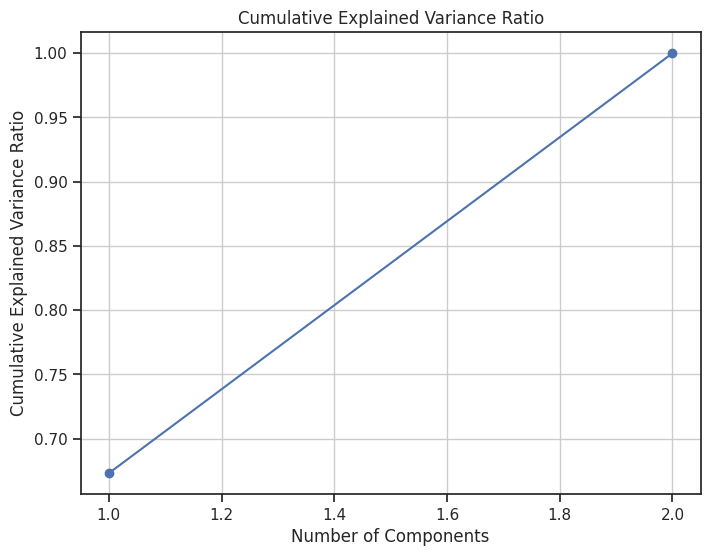

In [31]:
# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [32]:
#umap_df = pd.DataFrame(X_trans, columns = ["PC1", "PC2", "PC3"])
# Create a DataFrame for PCA results
umap_columns = [f'PC{i}' for i in range(1, num_components + 1)]
umap_df = pd.DataFrame(data=X_trans, columns=umap_columns)
umap_df

,PC1,PC2
0,11.436752,2.399500
1,8.809197,6.854354
2,11.717610,4.430830
3,9.024712,7.369956
4,10.271281,7.180761
...,...,...
17163,10.127772,1.680403
17164,14.430876,5.335926
17165,14.791485,2.121175
17166,14.457492,2.022176


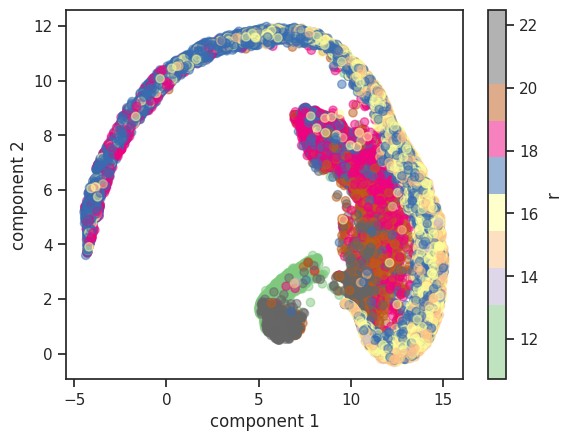

In [33]:
# Assuming umap_df is your DataFrame containing UMAP components and g_PStotal column
plt.scatter(umap_df["PC1"], umap_df["PC2"],
            c=df_cleanErr["r"],  # Set color based on the values of "g_PStotal"
            alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(label='r')  # Set the label of the color bar to 'g_PStotal'
plt.show()

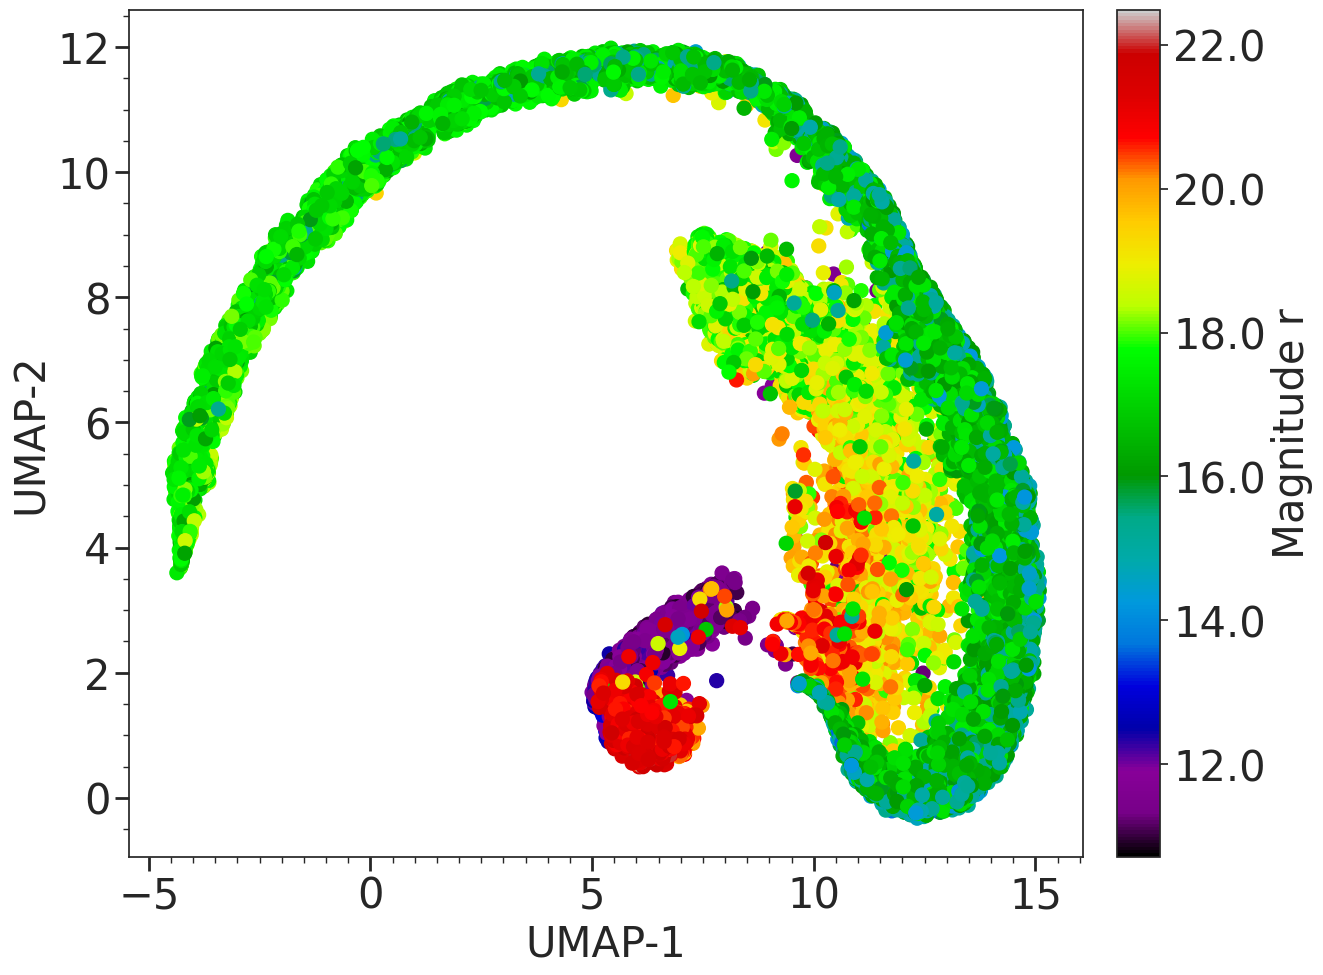

In [34]:
from matplotlib.ticker import MultipleLocator, NullFormatter

# Plotting
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(15, 11))
    plt.xlabel("UMAP-1", fontsize=30)
    plt.ylabel("UMAP-2", fontsize=30)
    plt.tick_params(axis='x', labelsize=30, width=2, length=10)  # Adjusting width of tick marks
    plt.tick_params(axis='y', labelsize=30, width=2, length=10)  # Adjusting width of tick marks

    # Create a scatter plot
    sc = ax.scatter(umap_df["PC1"], umap_df["PC2"], c=df_cleanErr["r"], cmap="nipy_spectral", s=100)
    
    # Add minor tick locators without showing the minor ticks
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())

    # Add a colorbar with improved visibility
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, format='%.1f')
    cbar.set_label("Magnitude r", fontsize=30)  # Provide a label for the colorbar
    cbar.ax.tick_params(labelsize=30)  # Adjust the size of the tick labels



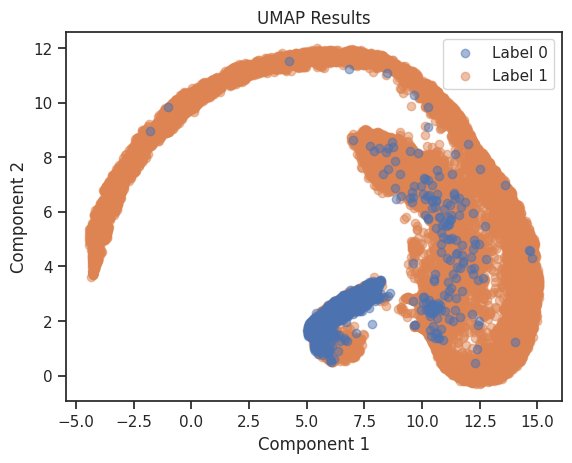

In [42]:

# Assuming umap_df is your DataFrame containing UMAP components
# Plot points with label 0
plt.scatter(umap_df.loc[combined_df["label"] == 0, "PC1"], umap_df.loc[combined_df["label"] == 0, "PC2"],
            label='Label 0', alpha=0.5, zorder = 2)

# Plot points with label 1
plt.scatter(umap_df.loc[combined_df["label"] == 1, "PC1"], umap_df.loc[combined_df["label"] == 1, "PC2"],
            label='Label 1', alpha=0.5, zorder = 1)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('UMAP Results')

# Add legend
plt.legend()

plt.show()

## HDBSCAN 

#### Find the best parameters 

To find the best min_samples and min_cluster_size parameters for HDBSCAN, you typically perform a grid search over a range of values and evaluate the clustering performance using a metric such as silhouette score or another relevant metric.

Here's a general approach you can follow:

    Define a grid of parameters to search over for min_samples and min_cluster_size.
    For each combination of parameters:
        Fit HDBSCAN to your data.
        Evaluate the clustering performance using a metric such as silhouette score.
    Select the parameters that result in the highest clustering performance according to your chosen metric.

Here's how you can perform this grid search:

In [ ]:

# Define the range of values for min_samples and min_cluster_size
min_samples_range = [5, 10, 15, 20, 25, 30, 35]  # Adjust as needed
min_cluster_size_range = [40, 50, 60, 80, 100, 120, 150]  # Adjust as needed

In [ ]:
best_score = -1
best_params = {}


In [ ]:
for min_samples in min_samples_range:
    for min_cluster_size in min_cluster_size_range:
        # Fit HDBSCAN with the current parameters
        clusterer_ = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
        labels = clusterer_.fit_predict(X_trans)  # X is your data
        
        # Evaluate clustering performance using silhouette score
        silhouette_ = silhouette_score(X_trans, labels)
        
        # Check if current parameters result in a better silhouette score
        if silhouette_ > best_score:
            best_score = silhouette_
            best_params['min_samples'] = min_samples
            best_params['min_cluster_size'] = min_cluster_size

In [ ]:
print("Best parameters:", best_params)
print("Best silhouette score:", best_score)

### Applying HDBSCAN 

I foun that the best configurations of parameteres are 'min_samples': 5 and 'min_cluster_size': 100. We try then: 
But first try this min_samples=15, min_cluster_size=60

In [ ]:
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=50, 
                             prediction_data=True, gen_min_span_tree=True)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=1, gen_min_span_tree=True)


In [ ]:

clusterer.fit(X_trans)
labels = clusterer.labels_
len(labels)

In [ ]:
clusterer.metric

In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_cluster0 = list(labels).count(0)
n_cluster1 = list(labels).count(1)
n_cluster2 = list(labels).count(2)
n_cluster3 = list(labels).count(3)
n_noise_ = list(labels).count(-1)


In [ ]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of cluster points 2: %d' % n_cluster2)
print('Estimated number of cluster points 3: %d' % n_cluster3)
print('Estimated number of noise points: %d' % n_noise_)

In [ ]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)


### Build the cluster hierarchy 

In [ ]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

### Extract the clusters

In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

Plting the components

In [ ]:

plt.figure(figsize=(9,7))
sns.scatterplot(x=umap_df["PC1"], y=umap_df["PC2"], 
                hue=labels,
                )

In [ ]:
# Concatenat the original claen table with the umap results
df_cleanErr.reset_index(drop=True, inplace=True)
umap_df.reset_index(drop=True, inplace=True)
df_cleanErr_umap = pd.concat([df_cleanErr, umap_df], axis=1)
df_cleanErr_umap

Create the tables for each clase

In [ ]:
df_cleanErr_umap["Label"] = labels

In [ ]:
df_cleanErr_umap

**Preliminary conlusions**\\
Wiht the parameters recomended by the Silhouette HDBSCAM fin two group, on which one corresponds to the EB. BUt using (min_samples=15, min_cluster_size=60 HDBCAM find four group one coressponds to to the EB, aother to CV and QSOS and AGN, and the other two to QSOS each one corresnp a specific redshift.

In [ ]:
# Group the data based on the "Label" column
grouped_data = df_cleanErr_umap.groupby("Label")

In [ ]:
# Define the directory where you want to save the CSV files
directory = '../Class_allflters_main_unique/'

In [ ]:
# Iterate over each group
for label, group_df in grouped_data:
    if label == -1:  # Noise points
        filename = f'Halpha_emitter_noise.csv'
    else:
        filename = f'Halpha_emitter_group{label}.csv'
    group_df.to_csv(directory + filename, index=False)